# <span style= "color:green"> CHAPTER 7 BASICS OF OBJECT DETECTION </SPAN>

## Regions Proposals

 ```SelectiveSearch is a region proposal algorithm used for object localization where it  generates proposals of regions that are likely to be grouped together based on their pixel intensities.```

In [1]:
#pip install selectivesearch

In [2]:
#pip install torch_snippets

In [5]:
from torch_snippets import *
import selectivesearch
from skimage.segmentation import felzenszwalb

2021-09-16 23:35:10.963 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [4]:
img = read('Hemanvi.jpeg', 1)

In [5]:
# Extract the felzenszwalb segments (which are obtained based on the
# color, texture, size, and shape compatibility of content within an image) from the image:

segments_fz = felzenszwalb(img, scale=200) #, scale represents the number of clusters that can be formed within the segments of the image.

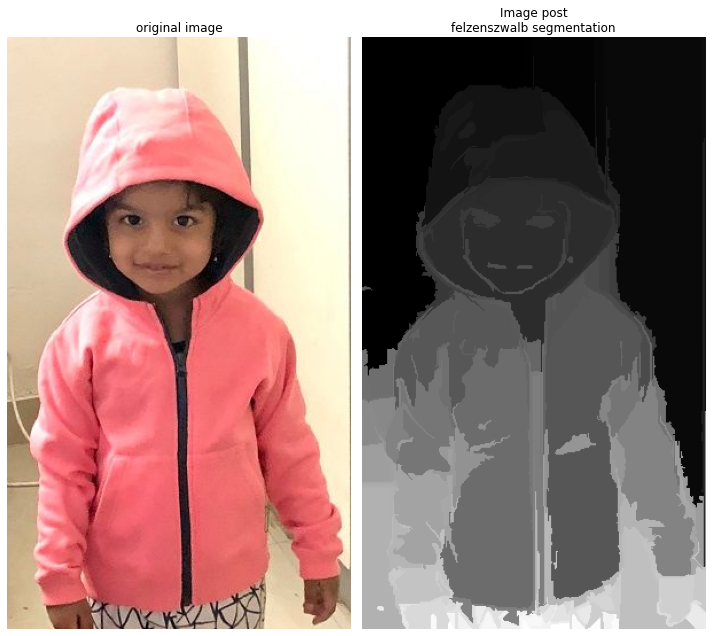

In [6]:
subplots([img, segments_fz], titles=['original image','Image post\nfelzenszwalb segmentation'], sz=10, nc=2)

## Implementing SelectiveSearch to generate region proposals


In [7]:
#this is used to train a R-CNN and/or Fast R-CNN

#1.  Define the ```extract_candidates``` function that fetches the region proposals from an image:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    #Calculate the image area and initialize a list that we will use to store the candidates that pass a defined threshold:
    img_area = np.prod(img.shape[:2])
    candidates = []
    #Fetch only those candidates (regions) that are over 5% of the total image area and less than or equal to 100% of the image area
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

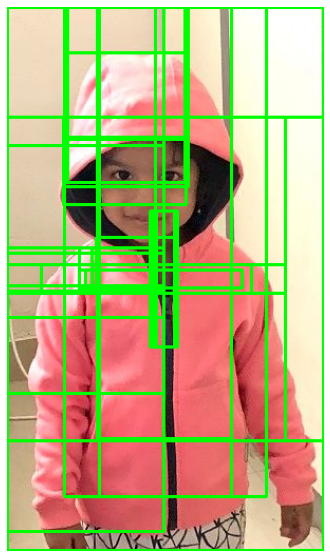

In [8]:
#let's try the function

candidates = extract_candidates(img)
show(img, bbs=candidates)

## Programming the IoU

In [10]:
#Let's define a function that takes two bounding boxes as input and returns IoU as the output:

def get_iou(boxA, boxB, epsilon = 1e-5):#boxA is the ground truth and boxB is the region proposal
                                        #We define the epsilon parameter to address the rare scenario when the
                                        #union between the two boxes is 0, resulting in a division by zero error
    x1 = max(boxA[0], boxB[0])#left
    y1 = max(boxA[1], boxB[1])#top
    x2 = min(boxA[2], boxB[2])#right
    y2 = min(boxA[3], boxB[3])#bottom
    
    #Calculate width and height corresponding to the intersection area
    width = (x2 - x1)
    height = (y2 - y1)
    
    #calculate the area of overlap
    if (width < 0)  or (height < 0):
        return 0.0
    area_overlap = width * height #basically, getting the area of  a rectangle
    
    #Calculate the combined area corresponding to the two bounding boxes. The area of both rectangles (for the denominator of the IoU)
    area_a = (boxA[2] - boxA[0] * (boxA[3] - boxA[1])) 
    area_b = (boxB[2] - boxB[0] * (boxB[3] - boxB[1]))
    area_combined = area_a + area_b - area_overlap #to not count the intersection
    
    #calculate the IoU
    iou = area_overlap / (area_combined + epsilon)
    return iou

## Implementing a R-CNN

In [11]:
#See the google colab notebook for the outputs. here is just the code and annotations

#Packages to import

import pandas as pd 
import numpy as np 
import torch
import selectivesearch

from torch_snippets import *
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Preparing the dataset

In [ ]:
IMAGE_ROOT = 'images/images' #where the images "supposedly" are

In [14]:
df_raw = pd.read_csv('D:/Data Science projects/pytorch/test-annotations-bbox.csv')

In [15]:
df_raw.head() #we can already see that labelname is wrong

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000026e7ee790996,xclick,/m/07j7r,1,0.071875,0.145313,0.206250,0.391667,0,1,1,0,0
1,000026e7ee790996,xclick,/m/07j7r,1,0.439063,0.571875,0.264583,0.435417,0,1,1,0,0
2,000026e7ee790996,xclick,/m/07j7r,1,0.668750,1.000000,0.000000,0.552083,0,1,1,0,0
3,000062a39995e348,xclick,/m/015p6,1,0.206208,0.849224,0.154639,1.000000,0,0,0,0,0
4,000062a39995e348,xclick,/m/05s2s,1,0.137472,0.376940,0.000000,0.883652,1,1,0,0,0


##  Define a class that returns the image and its corresponding class and ground truth along with the file path of the image:


In [ ]:
# Pass the data frame (df) and the path to the folder containing images (image_folder) as input to the __init__ method and fetch
# the unique ImageID values present in the data frame

class OpenImage(Dataset):
    def __init__(self, df, image_folder = IMAGE_ROOT):
        self.df = df
        self.root = image_folder
        self.unique_images = df['ImageID'].unique()
        
    def __len__(self): return len(self.unique_images)
    
    #Define the __getitem__ method, where we fetch:
    def __getitem(self, image_id, image_path, image, df)
    image_id = self.unique_images[ix] #he image (image_id) corresponding to an index (ix)
    image_path = f'{self.root}/{image_id}.jpg'
    image = cv2.imread(image_path, 1)[...,::-1]#convert BGR to RGB!
    h, w, _ = image.shape #get the height and width that will be used later for the boundingboxes
    df = self.df.copy()
    df = df[df['ImageID'] == 'image_id'] #get image (and information) from the dataframe according to a indexed image
    boxes = df['XMin, YMin, XMax, YMax'.split(',')].values #get the coordinates for each of these columns
    boxes = (boxes*np.array([w,h,w,h])).astype(np.uint16).tolist() #multiply by height and width of the image to square the ground truth objects
    classes = df['LabelName'].values().tolist()
    return image, boxes, classes, image_path

ds = openImages(df = DF_RAW)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, sz=10)

In [ ]:
#define the extract_iou and extract_candidates functions

def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

## Fetching region proposals and the ground truth of offset

In [ ]:
# Initialize empty lists to store file paths (FPATHS), ground truth bounding boxes (GTBBS), classes (CLSS) of objects, 
#the delta offset of a bounding box with region proposals (DELTAS), region proposal locations (ROIS), and the
# IoU of region proposals with ground truths (IOUS):

FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [],[],[],[],[],[]

In [ ]:
#run the previously defined functions------------------


# Loop through the dataset and populate the lists initialized above:
N = 500 #data points
for ix, (im, bbs, labels, fpath) in enumerate(ds): #basically this part "im, bbs, clss, _ = ds[9]"" but now we get the labels too
    if(ix==N):
        break
    #   
    H, W, _ = im.shape
    candidates = extract_candidates(im) #extract candidates from each image in absolute pixel values
    # convert the extracted regions (candidates) coordinates from an (x,y,w,h) system to an (x,y,x+w,y+h) system:
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    
    #Initialize ious, rois, deltas, and clss as lists that store iou for each candidate, region proposal location, bounding box offset, and class
    #corresponding to every candidate for each image.
    ious, rois, clss, deltas = [], [], [], []

    #Store the IoU of all candidates with respect to all ground truths for an image where bbs is the ground truth bounding box
    # and candidates are the region proposal candidates obtained in the previous step:
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    
    #Loop through each candidate and store the XMin (cx), YMin (cy), XMax (cX), and YMax (cY) values of a candidate:
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        
        #Extract the IoU corresponding to the candidate with respect to all the ground truth bounding boxes
        candidate_ious = ious[jx]
        
        #Find the index of a candidate (best_iou_at) that has the highest IoU and the corresponding ground truth (best_bb)
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        
       # If IoU (best_iou) is greater than a threshold (0.3), we assign the label of class corresponding to the candidate or the background
        if best_iou > 0.3: 
            clss.append(labels[best_iou_at])
        else : clss.append('background')
            
        #Fetch the offsets needed (delta or differences) to transform the current proposal into the candidate that is the best region proposal 
        #(which is the ground truth bounding box) – best_bb
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
        
    #Append the file paths, IoU, roi, class delta, and ground truth bounding  boxes  
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
    
#Fetch the image path names and store all the information obtained, FPATHS, IOUS, ROIS, CLSS, DELTAS, and GTBBS, in a list of lists
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [ ]:
# so far, classes are available as the name of the class. Now, we will convert them into their corresponding indices so that a
# background class has a class index of 0, a bus class has a class index of 1, and a truck class has a class index of 2

targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

## Prepare the Dataset

In [16]:
#normalize the image
normalize= transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [17]:
#define a function to preprocess the image: swithc chanels, noramlize and cuda

def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    img = img.to(device).float()

In [18]:
#define the function to the class decode prediction:

def decode(_y):
    _, preds = _y.max(-1)
    return preds

In [20]:
#Define the dataset (RCNNDataset) using the preprocessed region proposals along with the ground truths obtained

class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
        
    def __len__(self): return len(self.fpaths)
    
    #Fetch the crops as per the region proposals, along with the other ground truths related to class and the bounding box offset:
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    
    #Define collate_fn, which performs the resizing and normalizing (preprocess_image) of an image of a crop a
    
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

##  Create the training and validation datasets and data loaders:

In [ ]:
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

## R-CNN network architecture


In [ ]:
#Define a VGG backbone
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device)

In [ ]:
#define the model that will replace the last layer of the VGG layer

class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088
        
        #Define the backbone (self.backbone) and how we calculate the class score (self.cls_score) and the bounding box offset values
        #(self.bbox):
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        #Define the loss functions corresponding to class prediction (self.cel) and bounding box offset regression (self.sl1):
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
        
    #Define the feed-forward method where we pass the image through a VGG backbone    
    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    
    #Define the function to calculate loss (calc_loss).
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 0)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [ ]:
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [ ]:
#define the validation batch
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [ ]:
#Now, let's create an object of the model, fetch the loss criterion, and then define the optimizer and the number of epochs:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

In [ ]:
#We now train the model over increasing epochs:
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

In [ ]:
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf